In [267]:

from datetime import date
from io import StringIO
import boto3
import pandas as pd
import sys

def load_from_s3(bucket, key):
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket, key)
    body = obj.get()['Body']
    csv_string = body.read().decode('utf-8')
    df = pd.read_csv(StringIO(csv_string))
    return df

In [268]:
# Load in data

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)

PATH = "../data/"
df_cloudflare = pd.read_csv(f'{PATH}cloudflare.csv', low_memory=False, parse_dates=True)
traffic_total = df_cloudflare

df_active = load_from_s3('lakeneto-internal-public', 'raw/dataset-active-subscriptions/2020-5-9.csv')
df_active['merchant_id'] = df_active['reference']
df_active = df_active.drop(columns=['customerId','revenueLimit'])
df_active = df_active.set_index('reference')
df_active = df_active[~df_active.index.isna()]

In [269]:
df_mrr = pd.read_csv(f'{PATH}mrr.csv', low_memory=False, parse_dates=True)

In [270]:
df_idmap = pd.read_csv(f'{PATH}MerchantIDMap.csv', low_memory=False, parse_dates=True)
df_idmap = df_idmap.drop(columns=['blah'])
df_idmap = df_idmap.set_index('id')

In [271]:
df_activesites = df_active.join(df_idmap, how='left')
df_activesites['domain'] = df_activesites['domainprimary']
df_activesites = df_activesites.set_index('domainprimary').join(df_cloudflare.set_index('clientrequesthost'), how='left')

df_activesites

,status,planCode,planName,planFrequency.interval,merchant_id,domain,transfer,requests
4wdmania.neto.com.au,Active,plan-360-19q1,Neto 360 Plan,Monthly,N068523,4wdmania.neto.com.au,4.848624e+08,16661.0
Www.kindredspalace.com.au,Active,plan-s-19q1,Neto Small Plan,Monthly,N068753,Www.kindredspalace.com.au,NaN,NaN
aaronseyewear.neto.com.au,Active,plan-s-19q1,Neto Small Plan,Monthly,N059712,aaronseyewear.neto.com.au,2.199834e+07,844.0
abrasiflex.neto.com.au,Active,plan-s-19q1,Neto Small Plan,Monthly,N037299,abrasiflex.neto.com.au,1.474009e+06,39.0
actionsportsmx.neto.com.au,Active,plan-s-19q1,Neto Small Plan,Monthly,N017783,actionsportsmx.neto.com.au,NaN,NaN
...,...,...,...,...,...,...,...,...
zoomautoparts.neto.com.au,Active,plan-360-19q1,Neto 360 Plan,Monthly,N061402,zoomautoparts.neto.com.au,9.824200e+09,47847.0
NaN,Active,plan-s-19q1,Neto Small Plan,Monthly,N044239,NaN,NaN,NaN
NaN,Active,plan-s-19q1,Neto Small Plan,Monthly,N052462,NaN,NaN,NaN
NaN,Active,plan-s-19q1,Neto Small Plan,Monthly,N054952,NaN,NaN,NaN


In [272]:
df_final = df_activesites[~df_activesites['transfer'].isna()]

In [273]:
df_final = df_final.reset_index(drop=True)

df_final

,status,planCode,planName,planFrequency.interval,merchant_id,domain,transfer,requests
0,Active,plan-360-19q1,Neto 360 Plan,Monthly,N068523,4wdmania.neto.com.au,4.848624e+08,16661.0
1,Active,plan-s-19q1,Neto Small Plan,Monthly,N059712,aaronseyewear.neto.com.au,2.199834e+07,844.0
2,Active,plan-s-19q1,Neto Small Plan,Monthly,N037299,abrasiflex.neto.com.au,1.474009e+06,39.0
3,Active,plan-360-19q1,Neto 360 Plan,Monthly,N032167,admin.joolca.co.nz,7.142161e+07,24468.0
4,Active,plan-360-transition,Neto 360 (Foundation),Monthly,N005871,admin.joolca.com.au,2.565135e+09,62904.0
...,...,...,...,...,...,...,...,...
2379,Active,plan-s-19q1,Neto Small Plan,Monthly,N045789,z50.neto.com.au,2.653476e+06,18.0
2380,Active,plan-m-19q1,Neto Medium Plan,Monthly,N061087,zachspetshop.neto.com.au,2.211413e+09,99645.0
2381,Suspended,plan-m-19q1,Neto Medium Plan,Monthly,N066985,zinga.neto.com.au,3.008650e+06,34.0
2382,Active,plan-s-19q1,Neto Small Plan,Monthly,N061104,zivorauto.neto.com.au,5.968178e+10,309124.0


In [274]:
df_plan_agg = df_final.groupby('planCode').agg('mean')

In [275]:
df_plan_agg

,transfer,requests
planCode,,
on-hold-19q1,2.158667e+09,8.236583e+04
plan-360-19q1,1.019876e+11,2.527349e+06
plan-360-transition,2.034404e+11,4.740654e+06
plan-360-us,4.501744e+11,2.097100e+07
plan-l-19q1,6.037201e+10,1.227639e+06
plan-m-19q1,3.087963e+10,6.438986e+05
plan-m-us,7.899198e+09,2.580700e+05
plan-s-19q1,1.007588e+10,2.485590e+05
plan-xl-19q1,5.343768e+11,1.495212e+07


In [323]:
from scipy.stats import iqr
#iqr(df_final.groupby('planCode').transfer)

#“maximum”: Q3 + 1.5*IQR
#“minimum”: Q1 -1.5*IQR

#iqr = iqr(df_final[df_final['planCode'] == 'plan-s-19q1'].transfer)
#p25 = df_final[df_final['planCode'] == 'plan-s-19q1'].transfer.quantile([.25]).values[0]
#p75 = df_final[df_final['planCode'] == 'plan-s-19q1'].transfer.quantile([.75]).values[0]
#outlier_max = p75 + 1.5*iqr
#outlier_max

iqr = iqr(df_final[df_final['planCode'] == 'plan-s-19q1'].delta)
p25 = df_final[df_final['planCode'] == 'plan-s-19q1'].delta.quantile([.25]).values[0]
p75 = df_final[df_final['planCode'] == 'plan-s-19q1'].delta.quantile([.75]).values[0]
outlier_max = p75 + 1.5*iqr
outlier_max


16401766966.875

In [324]:
df_final[(df_final['planCode'] == 'plan-s-19q1') & (df_final['delta'] > outlier_max)]

,status,planCode,planName,planFrequency.interval,merchant_id,domain,transfer,requests,delta
134,Active,plan-s-19q1,Neto Small Plan,Monthly,N066771,housenliving.neto.com.au,2.614382e+10,122278.0,2.382915e+10
258,Active,plan-s-19q1,Neto Small Plan,Monthly,L003890,rugsntimber.mylistandsend.com,7.278975e+10,299605.0,7.047508e+10
282,Active,plan-s-19q1,Neto Small Plan,Monthly,N025101,shop.grittypretty.com,2.298220e+10,349860.0,2.066753e+10
293,Active,plan-s-19q1,Neto Small Plan,Monthly,N068333,shop.nurcha.com.au,2.216191e+10,627040.0,1.984724e+10
294,Active,plan-s-19q1,Neto Small Plan,Monthly,N059487,shop.peteraugustus.com.au,5.385617e+10,222628.0,5.154150e+10
...,...,...,...,...,...,...,...,...,...
2353,Active,plan-s-19q1,Neto Small Plan,Monthly,N009563,www.woodenitbegreat.com.au,2.561295e+10,1089607.0,2.329828e+10
2356,Active,plan-s-19q1,Neto Small Plan,Monthly,N042897,www.worldhobbies.com.au,3.617506e+10,1115703.0,3.386039e+10
2373,Active,plan-s-19q1,Neto Small Plan,Monthly,N001122,www.zax.com.au,4.260241e+10,656948.0,4.028774e+10
2374,Active,plan-s-19q1,Neto Small Plan,Monthly,N010741,www.zebraathletics.com.au,6.611918e+10,608953.0,6.380451e+10


In [322]:
df_final[df_final['planCode'] == 'plan-s-19q1'].count()

status                    1138
planCode                  1138
planName                  1138
planFrequency.interval    1138
merchant_id               1138
domain                    1138
transfer                  1138
requests                  1138
delta                     1138
dtype: int64

In [286]:
#df_plan_median = df_final.groupby('planCode').quantile([.25, .5, .75])
df_plan_median = df_final.groupby('planCode').quantile([.25, .5, .75])
df_plan_median

TypeError: 'quantile' cannot be performed against 'object' dtypes!

In [277]:
def calculate_delta(row):
    delta = row.transfer - plan_average
    return delta

#for plan in df_plan_agg.index.unique():
#    plan_average = df_plan_agg[df_plan_agg.index == plan].transfer.values[0]
#    df_final[df_final['planCode'] == plan].apply(calculate_delta, axis=1)
#    df_final['delta'] = df_final.apply(calculate_delta, axis=1)

s


#df_final[df_final['planCode'] == 'plan-m-19q1'].transfer.std()
#for row in df_final.itertuples():
#   df_final[" + str(row.Index + "]"))
#    #print("df_final[" + str(row.Index) + "]=" + str(row.merchant_id))
    


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a41cf74a8>,
      dtype=object)

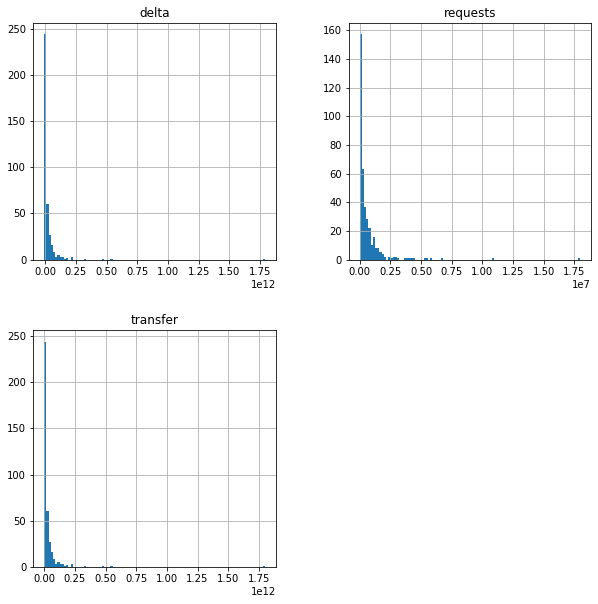

In [278]:
import matplotlib.pyplot as plt

df_final[df_final['planCode'] == 'plan-m-19q1'].hist(bins=100, figsize=(10,10))

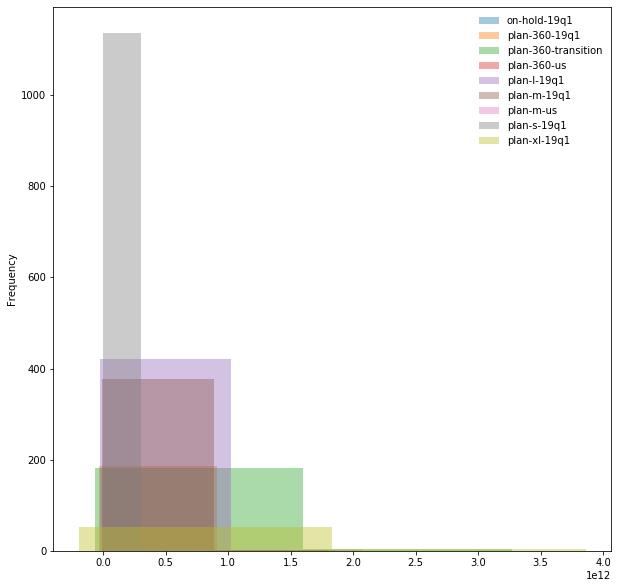

In [279]:
#df_final.groupby('planCode').delta.hist(bins=10, figsize=(10,10), alpha=0.4)

from matplotlib.pyplot import *
fig, ax = subplots()
df_final.groupby('planCode').delta.plot(kind='hist', bins=2, ax=ax, figsize=(10,10), alpha=0.4)
ax.legend(loc='upper right', frameon=False)
#ax.hlines(23, -.5,.5, linestyles='dashed')
#ax.annotate('average',(-0.4,23.5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3b68e710>,
      dtype=object)

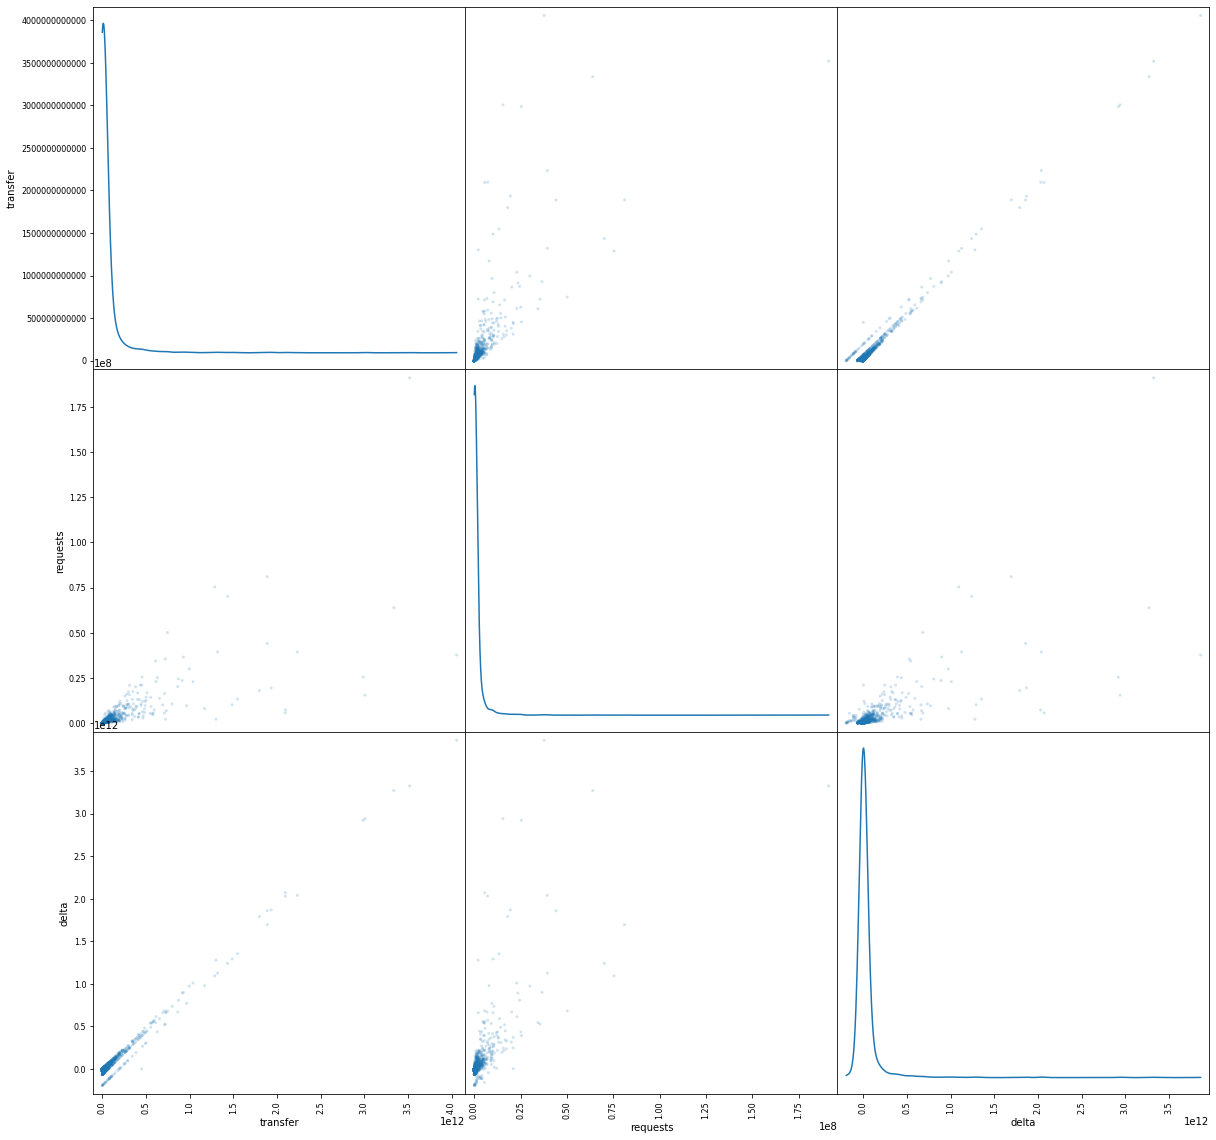

In [280]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_final, alpha=0.2, figsize=(20, 20), diagonal='kde')

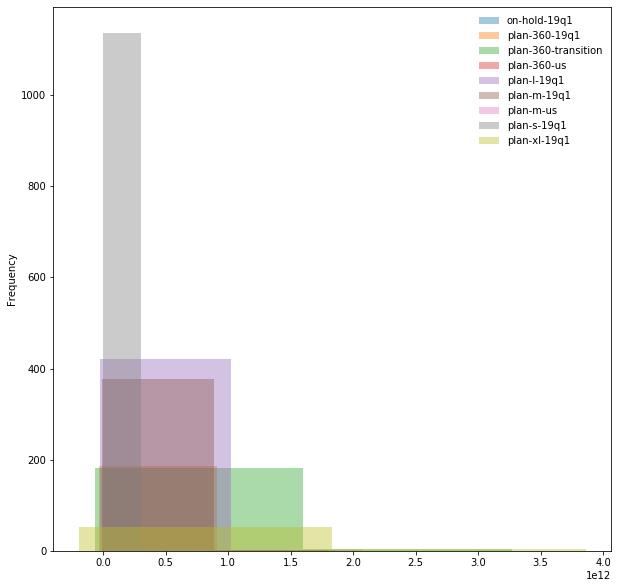

In [281]:
from matplotlib.pyplot import *
fig, ax = subplots()
df_final.groupby('planCode').delta.plot(kind='hist', bins=2, ax=ax, figsize=(10,10), alpha=0.4)
ax.legend(loc='upper right', frameon=False)

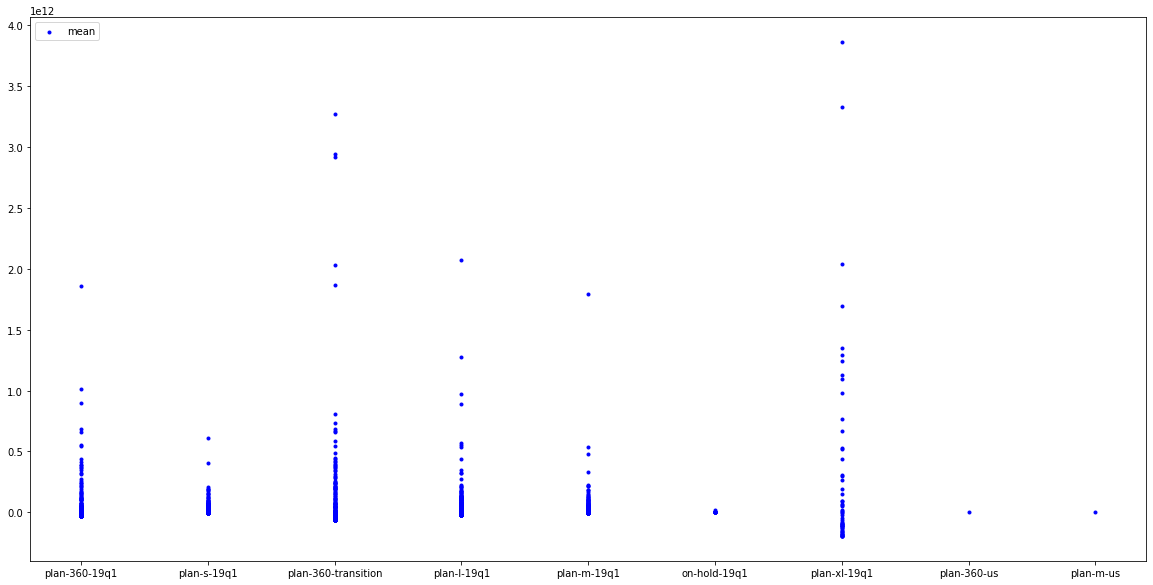

In [282]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

plt.scatter(df_final['planCode'], df_final['delta'], c='b', marker='.', label='mean')

plt.legend(loc='upper left')
plt.show()

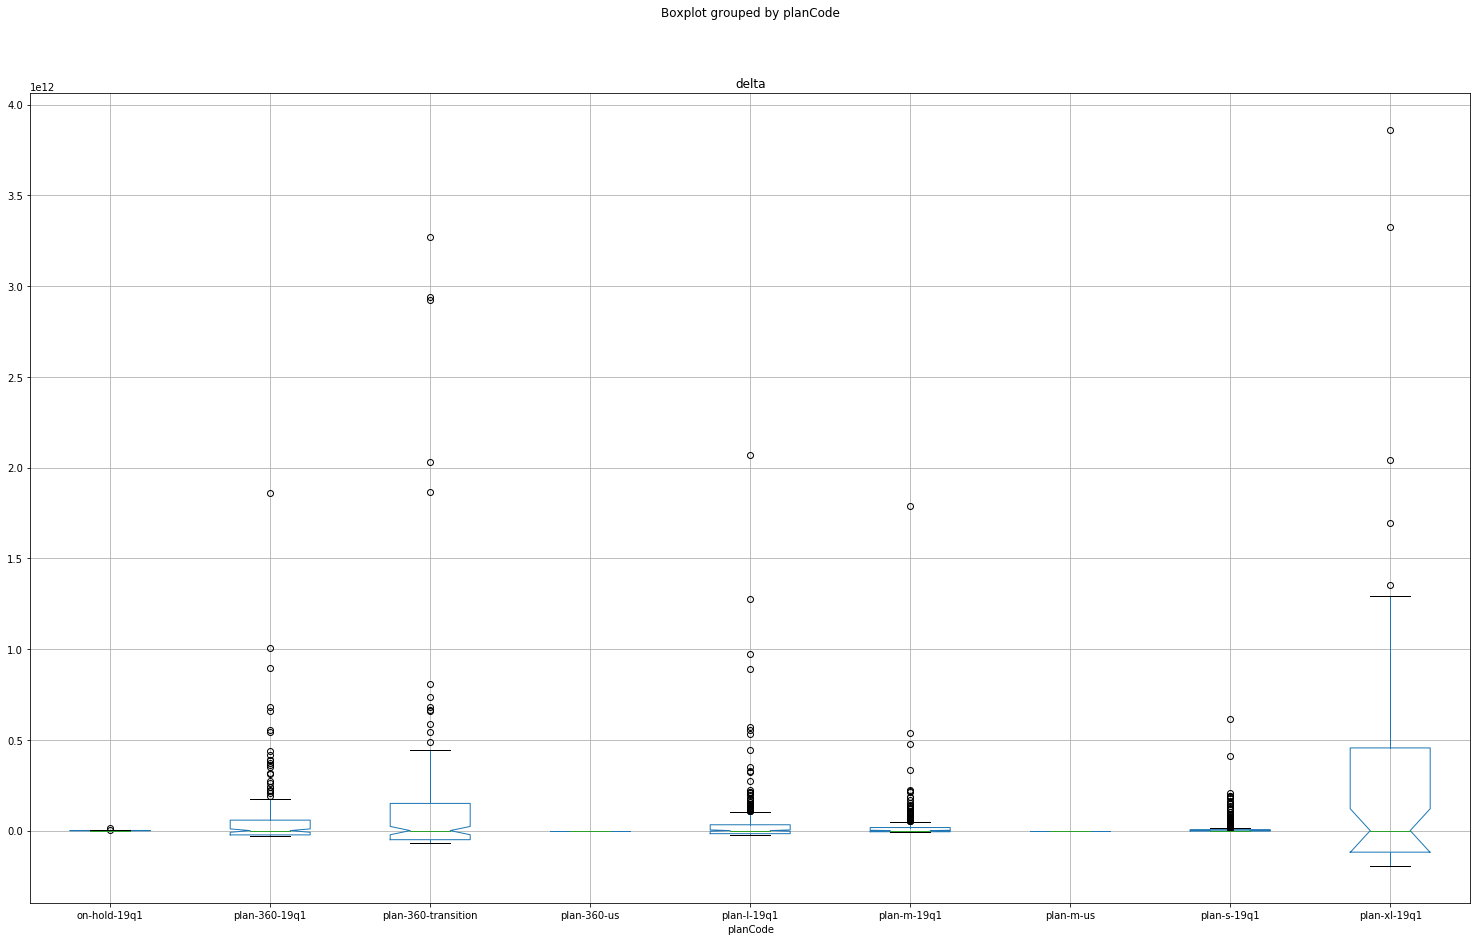

In [266]:
#df_final.boxplot(column=['delta', 'transfer'], by='planCode', figsize=(25,15))
df_final.boxplot(column=['delta'], by='planCode', figsize=(25,15), notch = True)

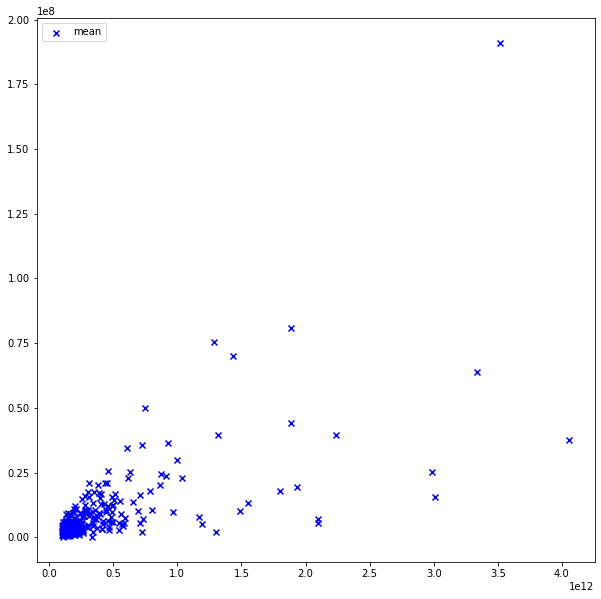

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(df_new['transfer'],df_new['requests'], c='b', marker='x', label='mean')

plt.legend(loc='upper left')
plt.show()

In [235]:
percentiles = df_raw.percentiles.apply(pd.Series)

percentiles = percentiles.rename(columns = {0: '25th', 1: 'median', 2: '75th',
                                            3: '95th', 4: '99th'}, 
                                            errors="raise")

df_raw = df_raw.join(percentiles, lsuffix='_caller', rsuffix='_other')



In [236]:
df_raw = df_raw.drop(columns=['percentiles'])

In [237]:
df_raw = df_raw.sort_values(by='month').sort_values(by='day')
df_raw['date'] = df_raw["month"].str.cat(df_raw["day"], sep ="/")

current_year = date.today().year

df_raw['date'] = df_raw['date'] + "/" + str(current_year)

df_raw['date'] = pd.to_datetime(df_raw['date'], errors='coerce')

In [238]:
df_plot = df_raw[df_raw['domain_name'] == "www.tumbarumbaoutfitters.com.au"]

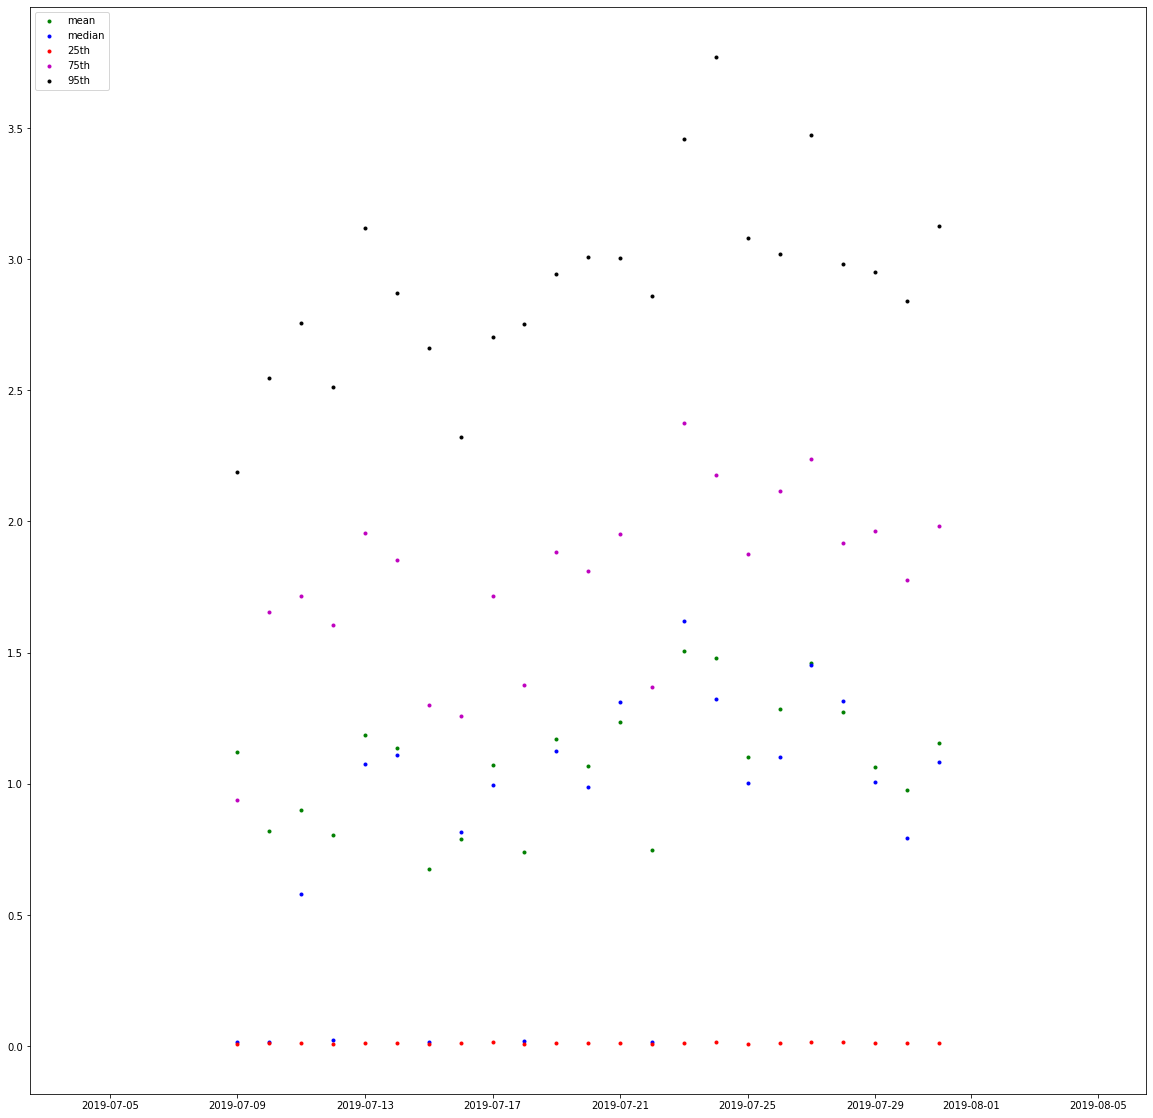

In [244]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.scatter(df_plot['date'],df_plot['mean'], c='g', marker='.', label='mean')
plt.scatter(df_plot['date'],df_plot['median'], c='b', marker='.', label='median')
plt.scatter(df_plot['date'],df_plot['25th'], c='r', marker='.', label='25th')
plt.scatter(df_plot['date'],df_plot['75th'], c='m', marker='.', label='75th')
plt.scatter(df_plot['date'],df_plot['95th'], c='k', marker='.', label='95th')
#plt.scatter(df_plot['date'],df_plot['99th'], c='y', marker='.', label='99th')

plt.legend(loc='upper left')
plt.show()

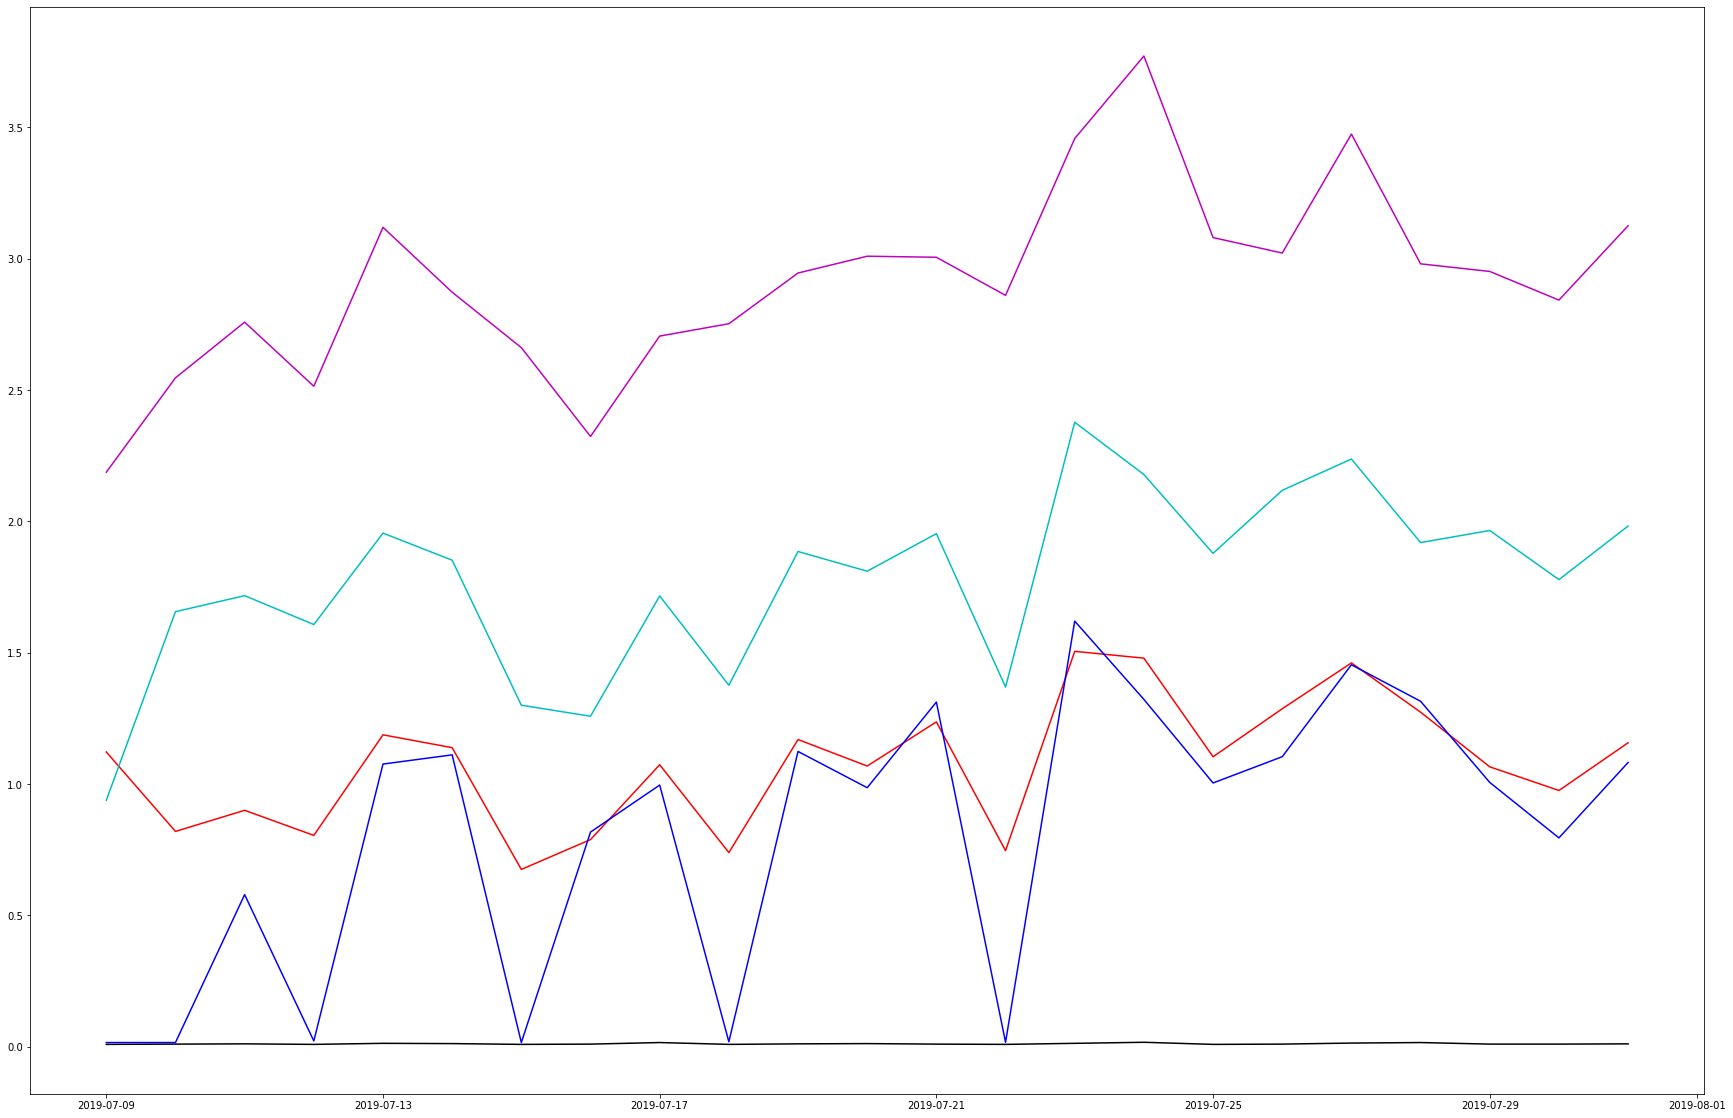

In [240]:
plt.figure(figsize=(30,20))
plt.plot(df_plot['date'], df_plot['mean'], 'r')
plt.plot(df_plot['date'], df_plot['median'], 'b')
plt.plot(df_plot['date'], df_plot['25th'], 'k')
plt.plot(df_plot['date'], df_plot['75th'], 'c')
plt.plot(df_plot['date'], df_plot['95th'], 'm')
#plt.plot(df_plot['date'], df_plot['99th'])